# crms_irf.ipynb

trying iterative random forests on random forest generated from both 
1. try irf on housekeeping gene subset of model for each cell type


based on https://github.com/Yu-Group/iterative-Random-Forest/blob/master/demo/28_iRF_demo_sklearn.ipynb

and the Iteratve Random Forest (Basu paper)





In [1]:
# basic packages
import os, glob
import pandas as pd
import numpy as np; np.random.seed(0)
import itertools
from collections import Counter, defaultdict
import time

# machine learning packages from sklearn
from sklearn.preprocessing import MinMaxScaler #StandardScaler 
from sklearn import preprocessing, metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve, plot_roc_curve, confusion_matrix, accuracy_score
from scipy import interp
from subprocess import call
from IPython.display import Image


# for IRF
from functools import reduce
# Needed for the scikit-learn wrapper function
import irf
from irf import (irf_utils, utils,
                 irf_jupyter_utils)
from irf.ensemble.wrf import RandomForestClassifierWithWeights
from math import ceil

# Import our custom utilities
from imp import reload


# Import tools needed for visualization
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import pydot

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
save_dir = '../data/processed/fig4_modelling/irf_manual'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
THRES=1

In [5]:
normal_tissues = ['Airway','Astrocytes','Bladder','Colon','Esophageal','GDSD0','GDSD3','GDSD6','GM12878','HMEC','Melanocytes','Ovarian',
'Pancreas','Prostate','Renal','Thyroid','Uterine']
normal_tissues_dict = dict(zip(normal_tissues,range(len(normal_tissues))))

# 0. Data Wrangling
- import
- preprocess


In [ ]:
# import
data_all = pd.read_csv('/Users/mguo123/Google Drive/1_khavari/omics_project-LD/pan_omics/data/processed/tissue_crms/all_count_comb_overall.csv',index_col=0,header=0)
data_all = data_all[data_all.tissue.isin(normal_tissues)]
data_all = data_all[data_all.iloc[:,2:].sum(axis=1)>1e-1]

# expression labels
# exp_label = list(data_all.exp.values)
labels_all  = data_all.tissue.values#np.array((data_all.exp>THRES).values)
tissue_num_labels =  data_all.tissue.map(normal_tissues_dict).values

genes_all = data_all.index.values
gene_to_num_dict = dict(zip(np.unique(genes_all),range(len(np.unique(genes_all)))))
genes_num_all = np.vectorize(gene_to_num_dict.get)(genes_all)



In [ ]:
print('files_loaded', data_all.shape)


In [ ]:
data_all[:5]

In [ ]:
## only tfs

data_all.drop(['tissue','exp','num_loop_counts','num_loops','num_atac_regions_pro','num_atac_regions_loop'],axis=1,inplace=True)

data_all.shape




In [ ]:
selector = VarianceThreshold()
data_all_varfilt = selector.fit_transform(data_all)
data_all_varfilt_cols = data_all.columns[selector.get_support()]
print(data_all.shape, data_all_varfilt.shape, len(data_all_varfilt_cols))
scaler = MinMaxScaler()
data_all_norm = scaler.fit_transform(data_all_varfilt)
data_all_norm = pd.DataFrame(data_all_norm, columns = data_all_varfilt_cols)

In [ ]:
data_all_norm[:5]

# A. Problem 1: try irf on housekeeping gene subset of model for each cell type

try GDSD3

## A.1 split data and run RF



future gene sets to test,
- housekeeping genes
- high expression genes
- all genes

In [27]:
# # get housekeeping genes
# housekeeping_df = pd.read_table(os.path.join('../../annon', 'HSIAO_HOUSEKEEPING_GENES.txt'),skiprows=2, header=None)
# housekeeping_df.columns = ['genes']
# housekeeping_genes_list = list(housekeeping_df.genes)
# len(housekeeping_genes_list)

# # tss_df_tissue = pd.read_csv('atac_footprinting/tss_footprints/GDSD3_tss_hoco_tf_exp_1000.csv', index_col=0)



398


for reference use values (rna spelling)
tissue_diffloop_to_rna = {
    'Air':'Airway', 'Astro':'Astrocyte', 'Blad':'Bladder', 'Colon':'Colon', 'Eso':'Esophageal', 
    'GDSD0':'GDSD0', 'GDSD3':'GDSD3', 'GDSD6':'GDSD6', 
    'GM12878':'GM12878', 'HMEC':'HMEC', 'MC':'Melanocytes', 'Ova':'Ovarian',
    'Panc':'Pancreas', 'Pros':'Prostate', 'Renal':'Renal', 'Thy':'Thyroid', 'Uter':'Uterine'
}


In [420]:
rf_tissue = 'Prostate'
gene_cluster = 'purple' # green, grey, purple, blue
tissue_specific = False

In [421]:
# option 1: use tpm1 cell type specific genes
if tissue_specific:
    cell_type_genes = pd.read_csv('../../rnaseq/unique_gene_lists/'+gene_cluster+'_genes.txt',header=None).loc[:,0]
    print(len(cell_type_genes))

    genes_bool = np.isin(genes_all, cell_type_genes)
    genes_bool_idx = np.where(genes_bool)[0]
    print('loaded genes tissue', len(genes_bool),len(genes_bool_idx))
# option 2 use group specific genes
else:
    gene_filepath = '../data/processed/fig1/rna/'+gene_cluster + '_genes.csv'
    cell_type_genes = pd.read_csv(gene_filepath,header=None).loc[:,0]

    genes_bool = np.isin(genes_all, cell_type_genes)
    genes_bool_idx = np.where(genes_bool)[0]
    print('loaded genes group', len(genes_bool),len(genes_bool_idx))

loaded genes group 156071 6315


In [422]:
# # takes a long time
# gene_in_hk_bool = np.isin(genes_all, housekeeping_genes_list)
# gene_in_hk_bool_idx = np.where(gene_in_hk_bool)[0]
# len(gene_in_hk_bool_idx)


In [423]:
# loop through all data
tissue_bool_labels = (labels_all==rf_tissue)
tissue_bool_idx = np.where(tissue_bool_labels)[0]
tissue_bool_idx.shape


(10675,)

In [424]:
select_idx = genes_bool_idx#list(set(tissue_bool_idx).intersection(gene_in_hk_bool_idx))
print(len(select_idx), data_all_norm.shape[0], len(select_idx)/data_all_norm.shape[0])


6315 156071 0.040462353672367064


In [425]:
# #### TESTING #####
# perc = .05
# num_sample = int(data_all_norm.shape[0]*perc)
# random_idx = np.random.choice(range(data_all_norm.shape[0]),num_sample,replace=False)
# print(perc, random_idx.shape[0], data_all_norm.shape[0])
# # num_sample = int(select_idx.shape[0]*perc)
# # random_idx = np.random.choice(select_idx,num_sample,replace=False)
# # print(perc, random_idx.shape[0], select_idx.shape[0])





In [426]:
Counter(tissue_bool_labels[select_idx])

Counter({False: 5810, True: 505})

In [427]:
train_features, test_features, train_labels, test_labels = train_test_split(np.array(data_all_norm)[select_idx,:], 
                                                                            tissue_bool_labels[select_idx], 
                                                                            test_size = 0.25, random_state = 42)



print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (4736, 647)
Training Labels Shape: (4736,)
Testing Features Shape: (1579, 647)
Testing Labels Shape: (1579,)


In [428]:
%%time
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100,#50, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0)
# Fit on training data
model.fit(train_features, train_labels)
# Actual class predictions
rf_predictions = model.predict(test_features)


CPU times: user 3.28 s, sys: 84.8 ms, total: 3.36 s
Wall time: 458 ms


In [429]:
model.predict_proba(test_features).shape

(1579, 2)

0.9404686510449651
[[1456   11]
 [  83   29]]
0.8490055019962994


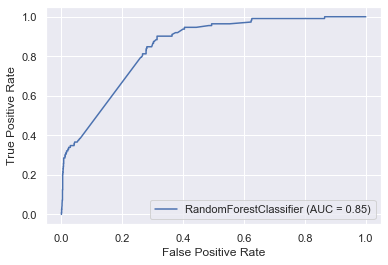

In [430]:
# evaluation
acc = accuracy_score(test_labels, rf_predictions)
print(acc)
# Probabilities for each class
rf_probs = model.predict_proba(test_features)[:, 1]
# Calculate roc auc
print(confusion_matrix(test_labels, rf_predictions))
roc_value = roc_auc_score(test_labels, rf_probs)
print(roc_value)
plot_roc_curve(model, test_features, test_labels) 
# Extract feature importances

In [431]:
# # Export as dot/png file
# # Extract single tree
# estimator = model.estimators_[5]

# dot_filepath = os.path.join(save_dir, 'test_'+rf_tissue+'_' + gene_cluster + '_tree.dot')
# png_filepath = os.path.join(save_dir, 'test_'+rf_tissue+'_' + gene_cluster + '_tree.dot')

# export_graphviz(estimator, 
#                 out_file=os.path.join(dot_filepath), 
#                 feature_names = data_all_norm.columns.values,
#                 class_names = ['not',rf_tissue],
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)
# cmd_arr = ['dot', '-Tpng', dot_filepath, '-o', png_filepath]
# print(' '.join(cmd_arr))
# call(cmd_arr)
# # Image(filename = png_filepath)


## A.2: Get all Random Forest and Decision Tree Data
Extract in a single dictionary the random forest data and for all of it's decision trees
This is as required for RIT purposes

In [432]:
%%time
all_rf_tree_data = utils.get_rf_tree_data(
    rf=model, X_train=train_features, X_test=test_features, y_test=test_labels)

# all_rf_tree_data = get_rf_tree_data(
#     rf=model, X_train=train_features, X_test=test_features, y_test=test_labels)

CPU times: user 34.7 s, sys: 1.33 s, total: 36 s
Wall time: 36.2 s


## A.3: Get the RIT data and produce RITs

RIT = random interaction tree

In [433]:
np.random.seed(12)
all_rit_tree_data = irf_utils.get_rit_tree_data(
    all_rf_tree_data=all_rf_tree_data,
    bin_class_type=1,
    M=100,
    max_depth=2,
    noisy_split=False,
    num_splits=2)
# Perform Manual CHECKS on the irf_utils
# These should be converted to unit tests and checked with nosetests -v test_irf_utils.py

## A.4: Plot and Evaluate Data
### List Ranked Feature Importances

In [434]:
# Print the feature ranking (from irf)
# print("Feature ranking:")

feature_importances_rank_idx = all_rf_tree_data['feature_importances_rank_idx']
feature_importances = all_rf_tree_data['feature_importances']

pd.DataFrame({'rank': range(1,train_features.shape[1]+1),
             'feature': data_all_varfilt_cols[feature_importances_rank_idx],
             'score':feature_importances[feature_importances_rank_idx]})
# for f in range(train_features.shape[1]):
#     print("%d. feature %s (%f)" % (f + 1
#                                    , data_all_varfilt_cols_1[feature_importances_rank_idx][f]
#                                    , feature_importances[feature_importances_rank_idx[f]]))

,rank,feature,score
0,1,KLF12_loop,0.080496
1,2,ZSCAN31_loop,0.026960
2,3,ZNF708_loop,0.021681
3,4,SP2_loop,0.021588
4,5,USF1_loop,0.019712
...,...,...,...
642,643,PBX2_pro,0.000000
643,644,MEF2C_pro,0.000000
644,645,NFATC2_pro,0.000000
645,646,USF1_pro,0.000000


In [435]:
# compare to what sklearn directly outputs
fi = pd.DataFrame({'feature': list(data_all_varfilt_cols),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head(10)

,feature,importance
551,KLF12_loop,0.080496
427,ZSCAN31_loop,0.026960
573,ZNF708_loop,0.021681
363,SP2_loop,0.021588
591,USF1_loop,0.019712
418,ZNF324_loop,0.018468
328,NR6A1_loop,0.013422
289,KLF4_loop,0.012761
332,PATZ1_loop,0.012572
240,E2F4_loop,0.011063


### Plot Ranked Feature Importances

In [436]:
# # Plot the feature importances of the forest
# feature_importances_std = all_rf_tree_data['feature_importances_std']

# plt.title("Feature importances")
# plt.bar(range(train_features.shape[1])
#         , feature_importances[feature_importances_rank_idx]
#         , color="r"
#         , yerr = feature_importances_std[feature_importances_rank_idx], align="center")
# plt.xticks(range(train_features.shape[1]), feature_importances_rank_idx)
# plt.xlim([-1, train_features.shape[1]])
# plt.show()

## A.5: Run the iRF function!


We will run the iRF with the following parameters
Data:
- CRM data
- random state (for reproducibility): 2018
Weighted RFs
- K: 5 iterations
- number of trees: 20
Bootstrap RFs
- proportion of bootstrap samples: 20%
- B: 30 bootstrap samples
- number of trees (bootstrap RFs): 5 iterations
RITs (on the bootstrap RFs)
- M: 20 RITs per forest
- filter label type: 1-class only
- Max Depth: 5
- Noisy Split: False
- Number of splits at Node: 2 splits


#### Running the iRF is easy - single function call
All of the bootstrap, RIT complexity is covered through the key parameters passed through in the main algorithm (as listed above)
This function call returns the following data:
m score

This is a lot of data returned! Will be useful when they build the interface later

In [437]:
%%time
all_rf_weights, all_K_iter_rf_data, \
all_rf_bootstrap_output, all_rit_bootstrap_output, \
stability_score = irf_utils.run_iRF(X_train=train_features,
                                    X_test=test_features,
                                    y_train=train_labels,
                                    y_test=test_labels,
                                    K=10,
                                    rf=RandomForestClassifierWithWeights(n_estimators=100),
                                    B=30,
                                    random_state_classifier=2018,
                                    propn_n_samples=.2,
                                    bin_class_type=1,
                                    M=25,
                                    max_depth=5,
                                    noisy_split=False,
                                    num_splits=2,
                                    n_estimators_bootstrap=5)

CPU times: user 8min 21s, sys: 29.7 s, total: 8min 51s
Wall time: 8min 50s


THIS IS WHAT WE CARE ABOUT `stability_score`

In [438]:
stability_score_names = {}
for feat_idx, score in sorted(stability_score.items(),key=lambda x:x[1],reverse=True):
    feat_names_arr = [data_all_varfilt_cols[int(x)] for x in feat_idx.split('_')]
    feat_names = '::'.join(feat_names_arr)
    stability_score_names[feat_names] = score
stability_df = pd.Series(stability_score_names)
save_file = os.path.join(save_dir, 'test_'+rf_tissue+'_' + gene_cluster + '_stability_score.csv')
stability_df.to_csv(save_file)
print(save_file)
stability_df

../data/processed/fig4_modelling/irf_manual/test_Prostate_purple_stability_score.csv


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


SP2_loop::KLF12_loop                                                                                                                                                                                         1.000000
KLF12_loop                                                                                                                                                                                                   1.000000
KLF12_loop::ZNF708_loop                                                                                                                                                                                      0.466667
ZSCAN31_loop::KLF12_loop                                                                                                                                                                                     0.433333
MAZ_loop::KLF12_loop                                                                                                                            

In [439]:
# freq_feat = pd.DataFrame(train_features, columns=data_all_varfilt_cols_1).sum(axis=0).sort_values(ascending=False)
# pd.DataFrame(freq_feat)[:20]

In [440]:
stability_df[['MITF' in x for x in stability_df.index.values]]

Series([], dtype: float64)

In [441]:
pd.DataFrame(stability_df)[:20]

,0
SP2_loop::KLF12_loop,1.000000
KLF12_loop,1.000000
KLF12_loop::ZNF708_loop,0.466667
ZSCAN31_loop::KLF12_loop,0.433333
MAZ_loop::KLF12_loop,0.400000
MAZ_loop::SP2_loop::KLF12_loop,0.366667
SP2_loop::KLF12_loop::ZNF708_loop,0.333333
SP2_loop::ZSCAN31_loop::KLF12_loop,0.333333
ZSCAN31_loop,0.300000
KLF12_loop::USF1_loop,0.300000


### Examine the stability scores

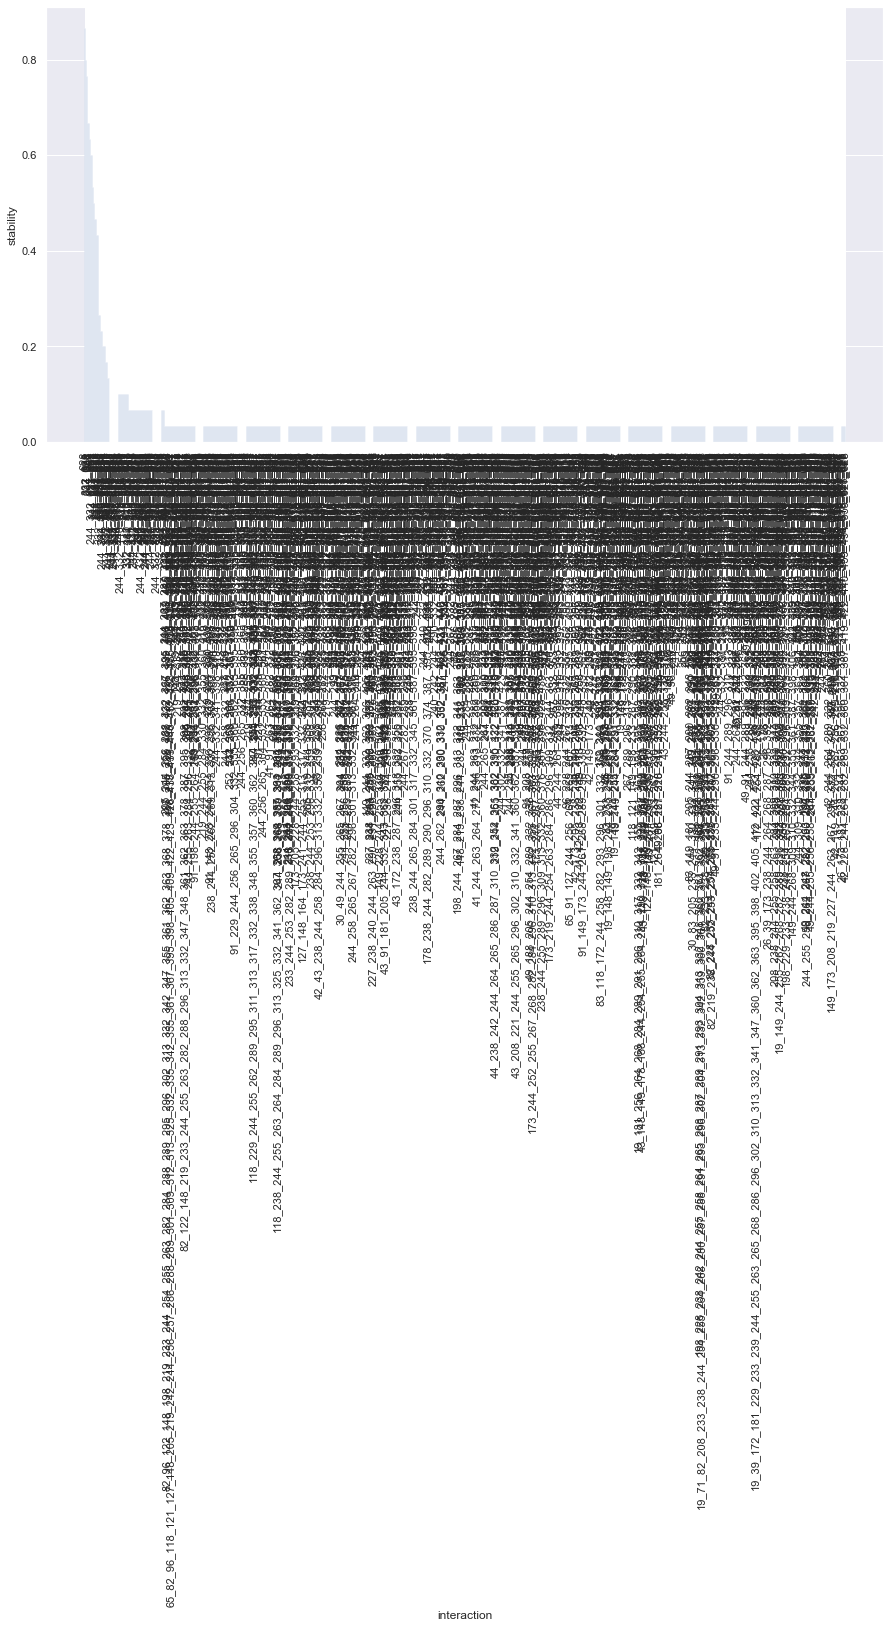

In [237]:
irf_jupyter_utils._get_histogram(stability_score, sort = True)

### Examine feature importances
In particular, let us see how they change over the K iterations of random forest

In [157]:
# for k in range(1, 6): 
    
#     iteration = "rf_iter{}".format(k)
    
#     feature_importances_std = all_K_iter_rf_data[iteration]['feature_importances_std']
#     feature_importances_rank_idx = all_K_iter_rf_data[iteration]['feature_importances_rank_idx']
#     feature_importances = all_K_iter_rf_data[iteration]['feature_importances']

#     plt.figure(figsize=(8, 6))
#     title = "Feature importances; iteration = {}".format(k)
#     plt.title(title)
#     plt.bar(range(train_features.shape[1])
#             , feature_importances[feature_importances_rank_idx]
#             , color="r"
#             , yerr = feature_importances_std[feature_importances_rank_idx], align="center")
#     plt.xticks(range(train_features.shape[1]), feature_importances_rank_idx, rotation='vertical')
#     plt.xlim([-1, train_features.shape[1]])
#     plt.show()

## A.6 Explore iRF Data Further
We can look at the decision paths of the Kth RF
Let's look at the final iteration RF - the key validation metrics

In [158]:
irf_jupyter_utils.pretty_print_dict(all_K_iter_rf_data['rf_iter5']['rf_validation_metrics'])
# {   'accuracy_score': 0.9649122807017544,
#     'confusion_matrix': array([[12,  2],
#        [ 0, 43]]),
#     'f1_score': 0.9772727272727273,
#     'hamming_loss': 0.03508771929824561,
#     'log_loss': 1.2119149470996806,
#     'precision_score': 0.9555555555555556,
#     'recall_score': 1.0,
#     'zero_one_loss': 0.03508771929824561}

{   'accuracy_score': 0.9524187153053132,
    'confusion_matrix': array([[1180,   10],
       [  50,   21]]),
    'f1_score': 0.411764705882353,
    'hamming_loss': 0.047581284694686754,
    'log_loss': 1.6434056936312003,
    'precision_score': 0.6774193548387096,
    'recall_score': 0.29577464788732394,
    'zero_one_loss': 0.04758128469468681}


Now plot the trees individually

In [92]:
#irf_jupyter_utils.draw_tree(decision_tree = all_K_iter_rf_data['rf_iter5']['rf_obj'].estimators_[0])

We can get this data quite easily in a convenient format

In [ ]:
# irf_jupyter_utils.pretty_print_dict(
#     all_K_iter_rf_data['rf_iter5']['dtree0']['all_leaf_paths_features'])

Notes comparing above combination against decision paths

In fact - we can go further and plot some interesting data from the Decision Trees. This can help us understand variable interactions better

In [ ]:
irf_jupyter_utils.pretty_print_dict(
    all_K_iter_rf_data['rf_iter5']['dtree0']['all_leaf_node_values'])

We can also look at the frequency that a feature appears along a decision path

In [ ]:
irf_jupyter_utils._hist_features(all_K_iter_rf_data['rf_iter5'], n_estimators = 20, \
                         title = 'Frequency of features along decision paths : iteration = 5')

### Run some Sanity Checks
Run iRF for just 1 iteration - should be the uniform sampling version
This is just a sanity check: the feature importances from iRF after 1 iteration should match the feature importance from running a standard RF
    

In [ ]:
all_K_iter_rf_data.keys()
print(all_K_iter_rf_data['rf_iter1']['feature_importances'])

Compare to the original single fitted random forest

In [ ]:
# rf = RandomForestClassifierWithWeights(n_estimators=20, random_state=2018)
# rf.fit(X=X_train, y=y_train)
print(model.feature_importances_)

Notes: And they match ____(well?) as expected.
